# <div align = "center">Load Payback Prediction</div>

---

By Stable Space

---

# Objective

- This notebook is a `Playground Competition (Predicting Loan Payback) Notebook`. You can find the link of the Competition here [https://www.kaggle.com/competitions/playground-series-s5e11].

- In this notebook,we will have a **Indepth Data Analysis** and will try to fit several **Models** to the data and will find one.

---

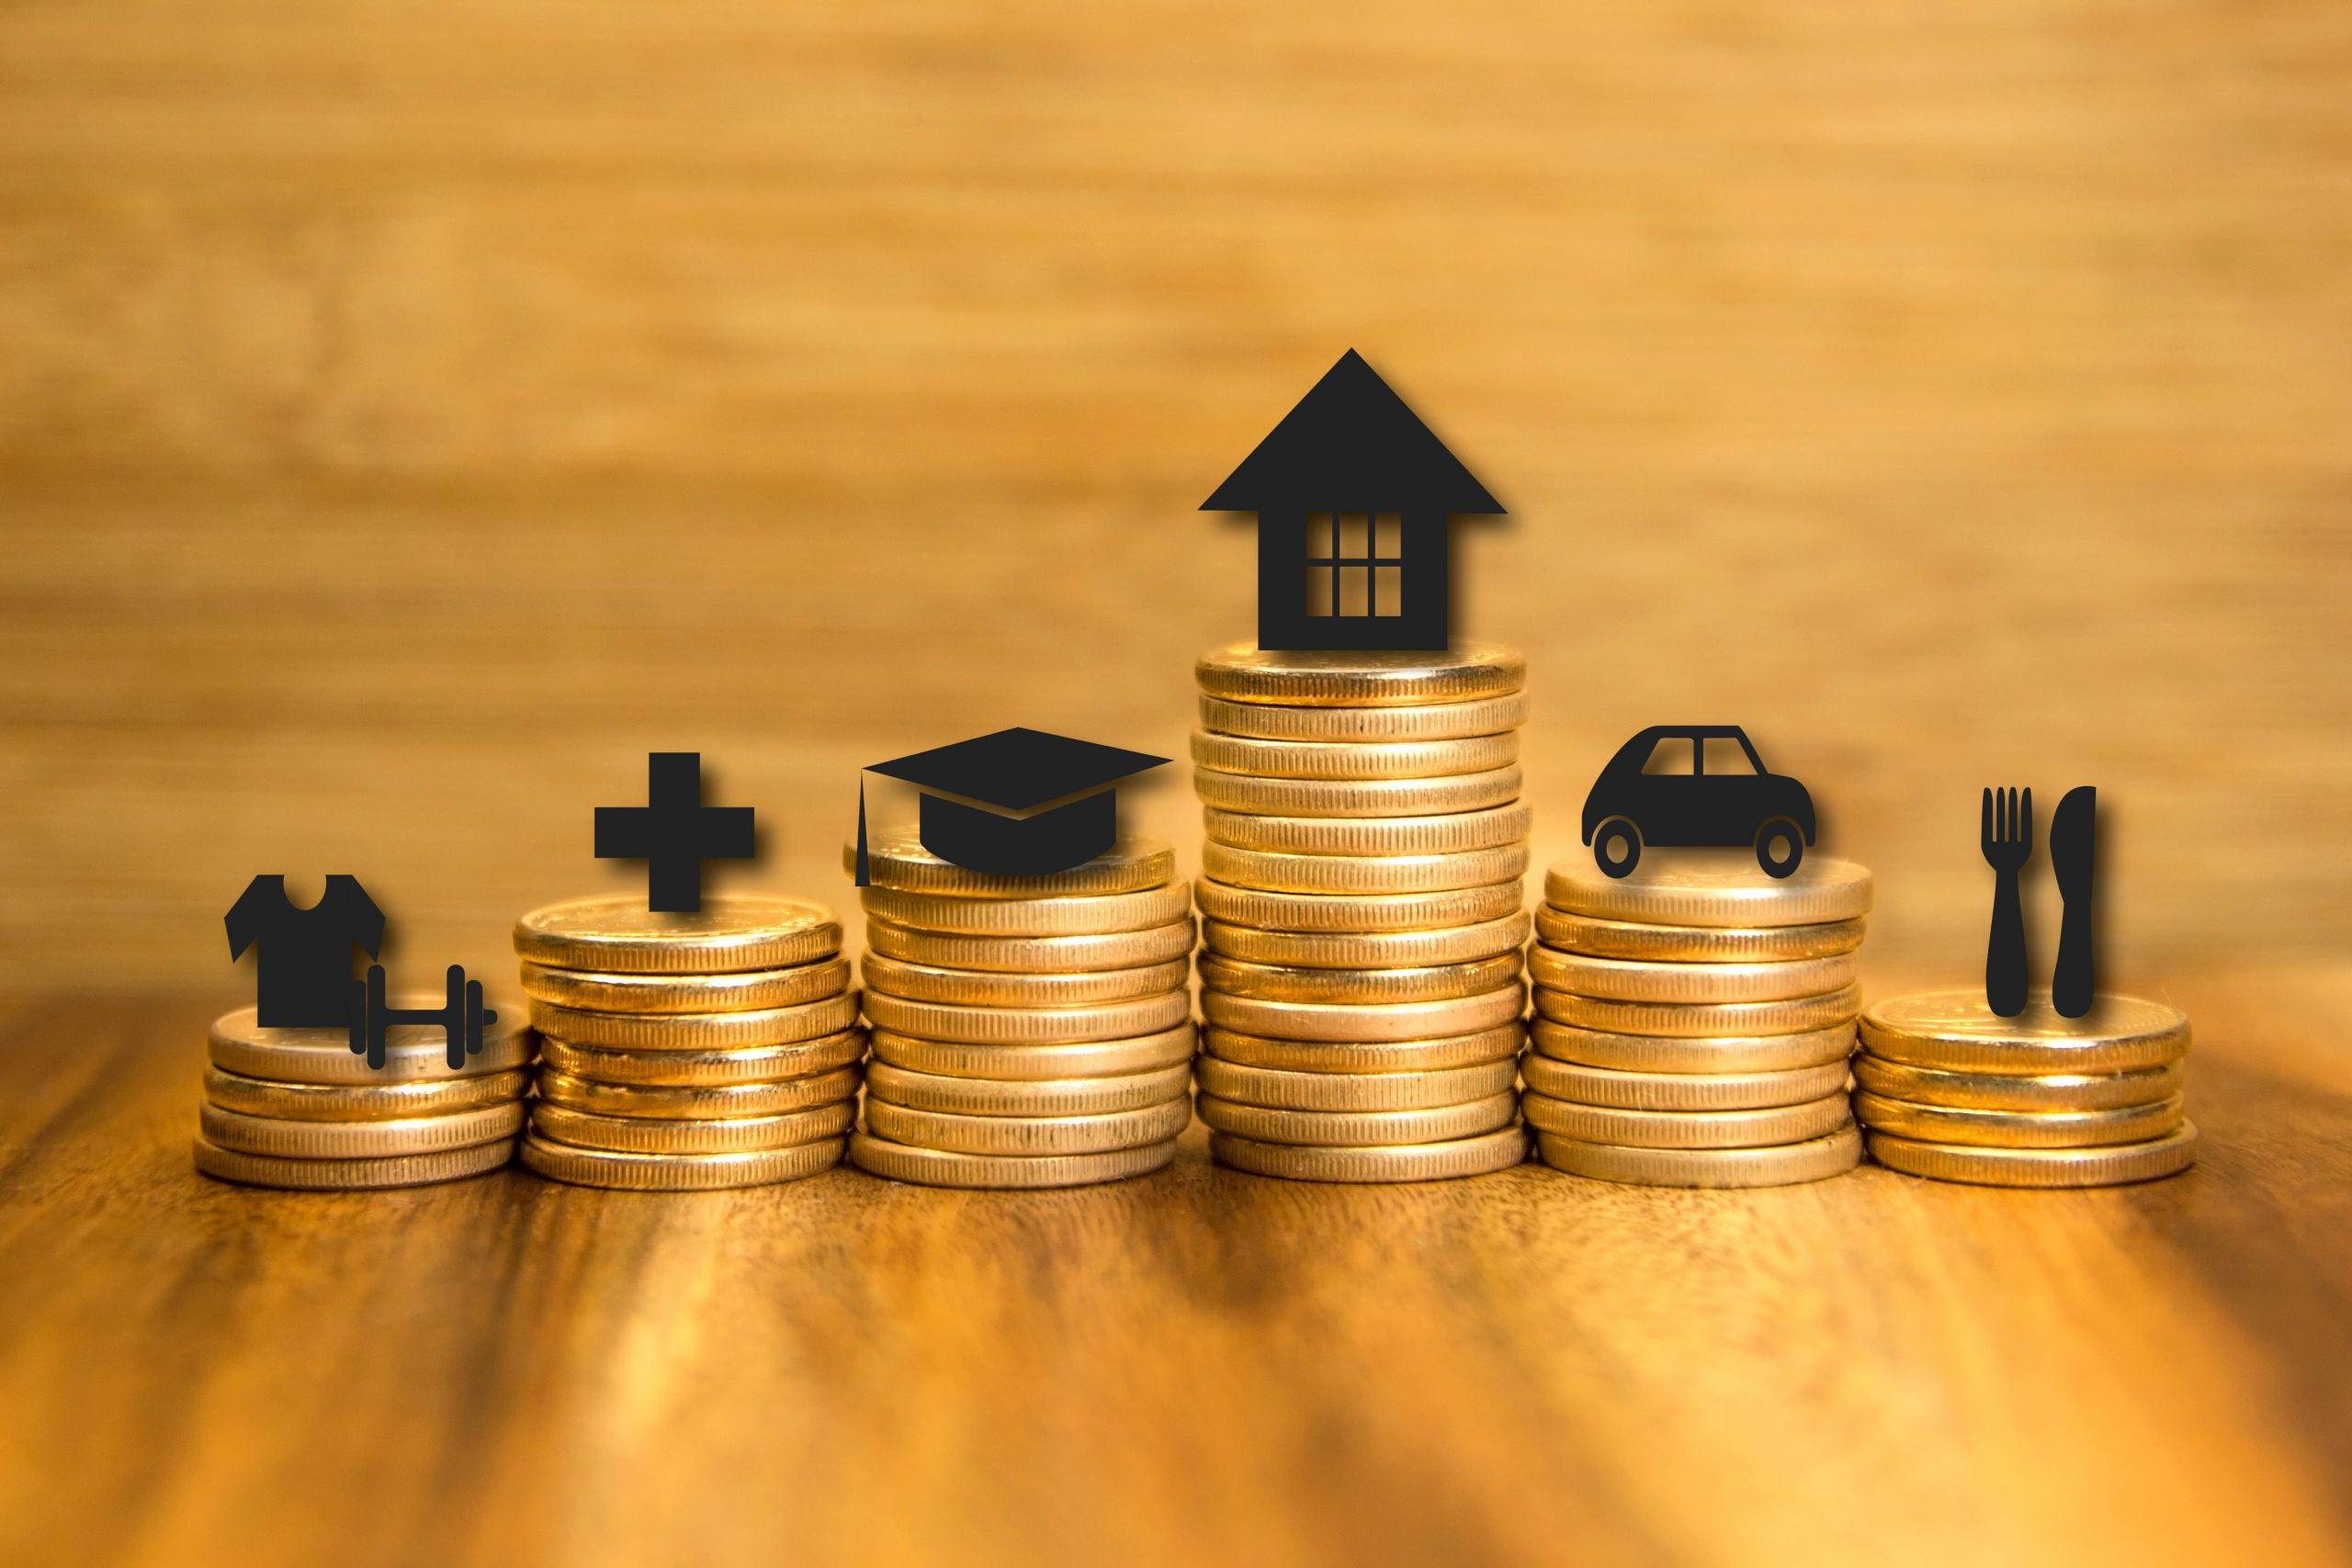

#### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool

#### Loading Files

In [ ]:
df_train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
df_sample = pd.read_csv("/kaggle/input/playground-series-s5e11/sample_submission.csv")

In [ ]:
df_train.drop(columns="id", inplace=True)

In [ ]:
df_test_full = df_test.copy()

In [ ]:
X = df_train.drop(columns="loan_paid_back")
Y = df_train["loan_paid_back"]

In [ ]:
categorical_cols = [
    "gender", "marital_status", "education_level",
    "employment_status", "loan_purpose", "grade_subgrade"
]

continuous_cols = [
    "annual_income", "debt_to_income_ratio",
    "credit_score", "loan_amount", "interest_rate"
]

In [ ]:
for col in continuous_cols:
    lower, upper  = X[col].quantile(0.01), X[col].quantile(0.99)
    X[col] = X[col].clip(lower, upper)
    df_test[col] = df_test[col].clip(lower, upper)

In [ ]:
# Ensure categorical columns are string
for col in categorical_cols:
    X[col] = X[col].astype(str)
    df_test[col] = df_test[col].astype(str)

## CatBoostClassifier

In [ ]:
df_test = df_test[X.columns]

cat_features = [X.columns.get_loc(col) for col in categorical_cols]

# ---------------------
# Model Parameters (GPU)
# ---------------------
params = {
    "iterations": 1000,
    "depth": 5,
    "learning_rate": 0.22775461488,
    "l2_leaf_reg": 7.46314929,
    "bagging_temperature": 0.0350283198,
    "border_count": 252,
    "random_strength": 1.59045421e-05,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "random_seed": 42,
    "verbose": False,
    "task_type": "GPU",          # Enable GPU
    "devices": "0"               # Use first GPU device
}

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

auc_scores = []
all_preds = []
oof_preds = np.zeros(len(Y))

# ---------------------
# Cross-validation with GPU
# ---------------------
for fold, (train_idx, val_idx) in enumerate(cv.split(X, Y), 1):
    print(f"\n🚀 Training Fold {fold} on GPU...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    Y_train, Y_val = Y.iloc[train_idx], Y.iloc[val_idx]

    train_pool = Pool(X_train, Y_train, cat_features=cat_features)
    val_pool = Pool(X_val, Y_val, cat_features=cat_features)

    model = CatBoostClassifier(**params, scale_pos_weight = len(Y[Y == 0]) / len(Y[Y == 1]))
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    Y_pred_proba = model.predict_proba(val_pool)[:, 1]
    auc = roc_auc_score(Y_val, Y_pred_proba)
    auc_scores.append(auc)
    oof_preds[val_idx] = Y_pred_proba

    # Predict on test data (GPU)
    test_pool = Pool(df_test, cat_features=cat_features)
    test_proba = model.predict_proba(test_pool)[:, 1]
    all_preds.append(test_proba)

    print(f"Fold {fold} AUC: {auc:.5f}")

# ---------------------
# Results
# ---------------------
print(f"\n✅ Mean AUC-ROC across folds: {np.mean(auc_scores):.5f}")

In [ ]:
df_test

In [ ]:
preds = np.mean(all_preds, axis = 0)
submission = pd.DataFrame({
    "id": df_test_full["id"],
    "load_paid_back": preds
})
submission.to_csv("submission.csv", index = False)
submission.to_csv("/kaggle/working/submission.csv", index = False)